In [1]:
from keras.applications.efficientnet_v2 import EfficientNetV2B3
from keras.preprocessing import image
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np
import shutil
import keras
import os

In [2]:
print(tf.__version__)

2.8.4


In [3]:
TARGET_SIZE = (540, 756)

In [4]:
MODEL_TRAIN = True
if MODEL_TRAIN:
    ds_train = tf.keras.utils.image_dataset_from_directory(
        'ds_train',
        labels='inferred',
        label_mode='binary',
        color_mode='rgb',
        batch_size=1,
        image_size=TARGET_SIZE,
        subset='training',
        seed=42,
        validation_split=0.2,
        interpolation='bilinear',
    )

    ds_valid = tf.keras.utils.image_dataset_from_directory(
        'ds_train',
        labels='inferred',
        label_mode='binary',
        color_mode='rgb',
        batch_size=1,
        image_size=TARGET_SIZE,
        subset='validation',
        seed=42,
        validation_split=0.2,
        interpolation='bilinear',
    )

    base_model = EfficientNetV2B3(
        weights='imagenet', include_top=False)
    base_model.trainable = False
    model = keras.Sequential([
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001),
                  metrics=[
                      'accuracy',
                      tf.keras.metrics.AUC()
                  ])
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    history = model.fit(
        ds_train,
        validation_data=ds_valid,
        epochs=1000,
        callbacks=[tf.keras.callbacks.EarlyStopping(
            patience=3, restore_best_weights=True, monitor='val_loss')],
    )
    # 713/713 [==============================] - 25s 36ms/step - loss: 2.2178e-05 - accuracy: 1.0000 - auc_2: 1.0000 - val_loss: 0.0033 - val_accuracy: 1.0000 - val_auc_2: 1.0000
    model.save('cleaning_model.h5')
else:
    model = keras.models.load_model('cleaning_model.h5')


Found 904 files belonging to 2 classes.
Using 724 files for training.
Found 904 files belonging to 2 classes.
Using 180 files for validation.
Num GPUs Available:  1
Epoch 1/1000
724/724 [==============================] - 83s 85ms/step - loss: 0.6296 - accuracy: 0.8177 - auc: 0.8771 - val_loss: 0.5827 - val_accuracy: 0.9333 - val_auc: 0.9691
Epoch 2/1000
724/724 [==============================] - 56s 77ms/step - loss: 0.5638 - accuracy: 0.9227 - auc: 0.9705 - val_loss: 0.5180 - val_accuracy: 0.9556 - val_auc: 0.9877
Epoch 3/1000
724/724 [==============================] - 55s 75ms/step - loss: 0.5045 - accuracy: 0.9461 - auc: 0.9864 - val_loss: 0.4600 - val_accuracy: 0.9611 - val_auc: 0.9908
Epoch 4/1000
724/724 [==============================] - 55s 75ms/step - loss: 0.4501 - accuracy: 0.9586 - auc: 0.9909 - val_loss: 0.4075 - val_accuracy: 0.9611 - val_auc: 0.9911
Epoch 5/1000
724/724 [==============================] - 54s 74ms/step - loss: 0.4004 - accuracy: 0.9627 - auc: 0.9926 - val

In [5]:
FOLDER_CLEANING = "deep/person"
img_paths = []
scores = []
for file in tqdm(os.listdir(FOLDER_CLEANING)):
    path = os.path.join(FOLDER_CLEANING, file)
    img = image.load_img(path, target_size=TARGET_SIZE, interpolation='bilinear')
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    img_paths.append(file)
    scores.append(pred[0][0])

100%|██████████| 1542/1542 [04:06<00:00,  6.24it/s]


In [6]:
THRESHOLD = 0.5

<AxesSubplot: >

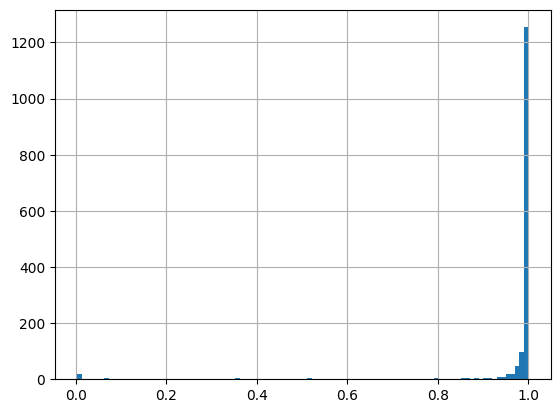

In [7]:
df = pd.DataFrame()
df['file'] = img_paths
df['score'] = scores
df.score.hist(bins=100)

In [8]:
df[df.score < 0.9].shape, df[df.score < 0.5].shape

((82, 2), (43, 2))

In [9]:
FOLDER_MOVETO = "deep/suspicious"
for a in tqdm(df[df.score < THRESHOLD].file):
    shutil.move(os.path.join(FOLDER_CLEANING, a), FOLDER_MOVETO)

100%|██████████| 43/43 [00:00<00:00, 997.80it/s]


In [10]:
    # model = tf.keras.models.Sequential([
    #     tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(
    #         TARGET_SIZE[0], TARGET_SIZE[1], 3)),
    #     tf.keras.layers.MaxPooling2D(2, 2),
    #     tf.keras.layers.Conv2D(32, (5, 5), activation='relu'),
    #     tf.keras.layers.MaxPooling2D(2, 2),
    #     tf.keras.layers.Conv2D(64, (7, 7), activation='relu'),
    #     tf.keras.layers.MaxPooling2D(2, 2),
    #     tf.keras.layers.Flatten(),
    #     tf.keras.layers.Dropout(0.2),
    #     tf.keras.layers.Dense(128, activation='relu'),
    #     tf.keras.layers.Dropout(0.2),
    #     tf.keras.layers.Dense(128, activation='relu'),
    #     tf.keras.layers.Dense(1, activation='sigmoid')
    # ])